## **Spindle detection**



In [29]:
import sys  
sys.path.insert(0, 'D:/Beths/')
import os
import re
import math
import pandas as pd
import numpy as np
import yasa
import mne
from mne.filter import filter_data, resample
import matplotlib.pyplot as plt
from scipy import signal

## Import from my files
from data_lfp import mne_lfp_Axona, load_lfp_Axona
from data_pos import RecPos

In [30]:
df = pd.read_csv('data_scheme.csv')
sleep_files = df.loc[df.sleep == 1, ['folder', 'filename']].agg('/'.join, axis=1).values

#### Auxiliary functions

In [31]:
def mark_moving(file, tresh=2.5): # 1 if speed > tresh
    pos = RecPos(file)
    speed = pos.get_speed()
    moving = np.zeros(len(speed)*5)
    for i in range(0, len(speed)): 
        if speed[i] > tresh:
            moving[5*i:5*i+5] = 1
    return moving

def create_events(record, events):
    '''Create events on MNE object
    Inputs:
        record(mne_object): recording to add events
        events_time(2D np array): array 0,1 with same lenght of recording dimension (1, lengt(record))
    output: 
    record(mne_object): Record with events added
    '''
    try:
        assert len(record.times) == events.shape[1]
        stim_data = events
        info = mne.create_info(['STI'], record1.info['sfreq'], ['stim'])
        stim_raw = mne.io.RawArray(stim_data, info)
        record.add_channels([stim_raw], force_update_info=True)
    except AssertionError as error:
        print(error)
        print('The lenght of events needs to be equal to record lenght.')
    return record

def plot_treshold(file):
    pos = RecPos(file)
    x, y = pos.get_position()
    resting = 1-mark_moving(file, tresh=1.) # 1-moving
    print(f'Proportion of resting time: {(100 * sum(resting))/len(resting):.1f}%')
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(6,3))
    ax.plot(x,y, c= 'black', alpha = .7) # plot background
    mx = np.asarray([n*m for n, m in zip(x, resting)])
    my = np.asarray([n*m for n, m in zip(y, resting)])
    mx[mx==0] = np.nan
    my[my==0] = np.nan
    ax.scatter(mx,my, c='r', marker='.',alpha = .5) 
    speed = pos.get_speed()
    ax1.hist(speed, bins=np.linspace(0,20))
    fig.tight_layout()
    return plt.show()

In [32]:
## Selecting files that the animal was not moving for > 20% of the recording
true_sleep = []
for file in sleep_files:
    pos = RecPos(file)
    x, y = pos.get_position()
    resting = 1-mark_moving(file, tresh=1.) # 1-moving
    if (100 * (sum(resting))/len(resting)) > 25:
        true_sleep.append(file.strip())
true_sleeps = [r.strip().split('/')[-1] for r in true_sleep]

In [33]:
sleep_files = df[df.filename.isin(true_sleeps)]

#### **Recordings which animals spent at least 25% of the time resting (speed < 1 cm/s)**

In [34]:
print(f'Number of animals with sleep recordings: {len(df[df.sleep == 1].rat.unique())}')
print(f'Number of animals with > 20% resting: {len(sleep_files.rat.unique())}')

Number of animals with sleep recordings: 14
Number of animals with > 20% resting: 14


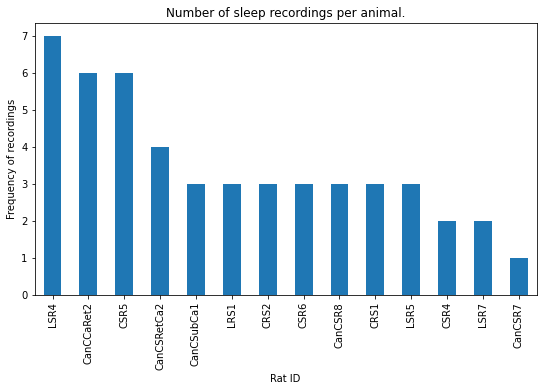

In [44]:
ax = sleep_files['rat'].value_counts().plot(kind='bar',
                                    figsize=(9,5),
                                    title="Number of sleep recordings per animal.")

ax.set_xlabel("Rat ID")
ax.set_ylabel("Frequency of recordings")
plt.show()

In [ ]:
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)  
epochs = mne.Epochs(raw, events, event_id=1, tmin=-0.2, tmax=0.5,  
                     proj=True, picks=picks, baseline=(None, 0),  
                     preload=True, reject=reject)  